In [1]:
import warnings
warnings.filterwarnings('ignore')

# data processing
import pandas as pd
import numpy as np

# image processing
from PIL import Image

# data visualization
import matplotlib.pyplot as plt
import seaborn as sn

# tf and keras
import tensorflow as tf
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization
from keras.layers.core import Dense, Activation, Flatten
from keras.optimizers import SGD, Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# dataset processing, ml models and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scipy
import glob
# import itertools

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_rows',None)

In [4]:
dir_ = 'HASYv2/'
K.set_image_data_format('channels_first')

---
---
# Functions

In [5]:
def read_csv(path):
    return pd.read_csv(dir_ + path)

#### Image Processing

In [6]:
# Image Preprocessing
def remove_transparency(im, bg_colour=(255, 255, 255)):

    # Only process if image has transparency 
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL 
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format

        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

def preprocess_img(path):
    # Open Image
    im = Image.open(dir_ + path)
    
    # Resize image to 32 by 32
    if im.size != (32,32):
        im = im.resize((32,32))
        
    # Convert image to a single greyscale channel
    im = remove_transparency(im).convert('L')
    
    # Convert image to numpy array
    I = np.asarray(im)
    
    #Close image
    im.close()
    
    return I

#### Dataset Preprocessing and Postprocessing

In [7]:
def populate_images(dataset):
    temp = []
    for i in range(len(dataset)):
        path = dataset.iloc[i]['path']
        pathsplit = path.split('/')
        if len(pathsplit) > 2:
            path = '/'.join([pathsplit[-2],pathsplit[-1]])
        img = preprocess_img(path)
        temp.append(img)
    dataset['img'] = [i for i in temp]
    return dataset

def convert_to_one_hot_encode(data, no_categories):
    data = np.array(data).reshape(-1)
    print('len of dataset', len(data))
    return np.eye(no_categories)[data]

# to process output to the value
# returns a list with all the categories with more than 50% accuracy
def one_hot_encode_to_char(arr, threshold=0.5, get_max=True):
    result = []
    val = 0
    for i in range(len(arr)):
        if arr[i] >= threshold:
            result.append((val, arr[i]))
        val +=1
    _max = []
    high = 0
    if get_max:
        for i in result:
            if i[1] > high:
                _max = [i[0]]
                high = i[1]
        return _max
    else:
        return [i[0] for i in result]

def convert_pred_list_ohe_to_labels(pred_data, threshold=0.5, get_max=True):
    result = []
    for i in range(len(pred_data)):
        val = one_hot_encode_to_char(pred_data[i], threshold=threshold, get_max=get_max)
        if len(val) > 0:
            if get_max == True:
                result.append(val[0])
            else:
                result.append(val)
        else:
            result.append(None)
            print(":( :( :(")
    return result

#### Dataset Splitting

In [8]:
# Stratified Train Test Split (new function)
def get_df_split(ds, stratify_col, test_size=0.2):
    _train, _test = train_test_split(ds, test_size=test_size, stratify=ds[stratify_col])
    return _train, _test

# function to split whole dataset at once (old function)
def gen_x_y_train_test_stratified_1df(dataset, input_shape, test_size=0.2):
    x = np.array(list(dataset['img']))
    y = np.array(list(dataset['symbol_id_ohe']))
    x = x.reshape((x.shape[0],1,input_shape[1],input_shape[2]))
    # Normalize data to 0-1
    x = x.astype("float32") / 255.0
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size,  stratify=y)
    return X_train, X_test, y_train, y_test

# function to process already split data
def process_x_y_train_test_stratified_2df(_tr, _ts, input_shape):
    # train df
    X_train = np.array(list(_tr['img']))
    y_train = np.array(list(_tr['symbol_id_ohe']))
    X_train = X_train.reshape((X_train.shape[0],1,input_shape[1],input_shape[2]))
    # Normalize data to 0-1
    X_train = X_train.astype("float32") / 255.0
    # test df
    X_test = np.array(list(_ts['img']))
    y_test = np.array(list(_ts['symbol_id_ohe']))
    X_test = X_test.reshape((X_test.shape[0],1,input_shape[1],input_shape[2]))
    # Normalize data to 0-1
    X_test = X_test.astype("float32") / 255.0
    
    return X_train, X_test, y_train, y_test

#### Dataset metrics

In [9]:
# generate label counts for dataframe and list
def get_label_count_df(df_train, df_test, sym_list):
    train_labels_count = {}
    test_labels_count = {}
    perc_labels_count = {}
    for i in sym_list:
        train_labels_count[i] = 0
        test_labels_count[i] = 0
    for i in range(len(df_train)):
        train_labels_count[df_train.loc[i,'symbol_id']] += 1
    for i in range(len(df_test)):
        test_labels_count[df_test.loc[i,'symbol_id']] += 1
    for i in sym_list:
        perc = (train_labels_count[i] / (train_labels_count[i] + test_labels_count[i])) * 100
        perc_labels_count[i] = (train_labels_count[i], test_labels_count[i], round(perc,2))
    return perc_labels_count

def get_label_count_list(lst_data, sym_list):
    labels_count = {}
    for i in sym_list:
        labels_count[i] = 0
    for i in range(len(lst_data)):
        j = one_hot_encode_to_char(lst_data[i])[0]
        labels_count[j] += 1
    return labels_count

### Convolutional Neural Networks

In [10]:
# CNN without Batch Normalization
def get_layers(input_shape, data_format, classes):
    return [
        Conv2D(25, (5, 5), padding='same', data_format=data_format, input_shape=input_shape),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(50, (3, 3), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                
        Conv2D(100, (2,2), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(200, (2,2), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Flatten(),
        Dense(3200),
        Activation('relu'),
        
        Dense(1600),
        Activation('relu'),
        
        Dense(classes),
        Activation('softmax'),
    ]

def create_network_1(input_shape, data_format, classes):
    model = Sequential()
    layers = get_layers(input_shape, data_format, classes)
    for i in layers:
        model.add(i)
    return model                

In [11]:
# CNN with Batch Normalization
def get_layers_bn(input_shape, data_format, classes):
    return [
        Conv2D(25, (5, 5), padding='same', data_format=data_format, input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(50, (3, 3), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                
        Conv2D(100, (2,2), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(200, (2,2), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Flatten(),
        Dense(3200),
        Activation('relu'),
        
        Dense(1600),
        Activation('relu'),
        
        Dense(classes),
        Activation('softmax'),
    ]

def create_network_2(input_shape, data_format, classes):
    model = Sequential()
    layers = get_layers_bn(input_shape, data_format, classes)
    for i in layers:
        model.add(i)
    return model                

#### Metrics

In [12]:
def t_test(test_x, test_y, models, sym2latex_dict):
    if len(models) < 0:
        raise ValueError("No models found in models variable")
    if len(test_x) != len(test_y):
        raise ValueError("Varibales test_x and test_y are of different length")
    
    # convert test values from one hot encoded to label value
    y_true = []
    for i in range(len(test_y)):
        # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
        val = one_hot_encode_to_char(test_y[i], threshold = 0.9, get_max=True)
        if len(val) > 0:
            y_true.append(val[0])
        else:
            y_true.append(None)
            print(":(")
    no_models = len(models)
    cols = ['symbol','latex']
    preds = []
    # convert predictions from one hot encoded to label value
    for i in range(no_models):
        print("Predictng labels for Model "+str(i))
        cols.append('model'+str(i))
        
        res = models[i].predict(X_test)
        y_pred = []
        for j in range(len(res)):
            # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
            val = one_hot_encode_to_char(res[j], threshold = 0.1, get_max=True)
            if len(val) > 0:
                y_pred.append(val[0])
            else:
                y_pred.append(None)
                print(":(")
        preds.append(y_pred)
    print("Predictions Done")
    print("Comparing Results...")
    
    # perform t test
    t_test_result = pd.DataFrame(columns=cols)
    for i in range(len(y_true)):
        t_test_result.loc[i,'symbol'] = y_true[i]
        t_test_result.loc[i,'latex'] = sym2latex_dict[y_true[i]]
        for j in range(no_models):
            t_test_result.loc[i, 'model'+str(j)] = sym2latex_dict[preds[j][i]]
    print("Done")    
    return t_test_result

def create_t_test_report(test_res):
    models_names = list(test_res.columns.values[2:])
    res = pd.DataFrame(columns=['latex','total_count']+models_names)
    for i in range(len(symbols)):
        res.loc[i,'latex'] = symbols.loc[i,'latex']
        res.loc[i,'total_count'] = 0
        for j in models_names:
            res.loc[i,j] = 0
    for i in range(len(test_res)):
        res.loc[test_res.loc[i,'symbol'],'total_count'] += 1
        for j in models_names:
            if test_res.loc[i,'latex'] == test_res.loc[i,j]:
                res.loc[latex2sym[test_res.loc[i,j]],j] += 1
    for i in range(len(res)):
        for j in models_names:
            res.loc[i,j+'_acc'] = (res.loc[i,j]/res.loc[i,'total_count']) * 100
    return res

---
# LABELS

In [13]:
orig_dataset = read_csv('hasy-data-labels.csv')
print(orig_dataset.head())
print('-----------------')
print(orig_dataset.info())

                     path  symbol_id latex  user_id
0  hasy-data/v2-00000.png         31     A       50
1  hasy-data/v2-00001.png         31     A       10
2  hasy-data/v2-00002.png         31     A       43
3  hasy-data/v2-00003.png         31     A       43
4  hasy-data/v2-00004.png         31     A     4435
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168233 entries, 0 to 168232
Data columns (total 4 columns):
path         168233 non-null object
symbol_id    168233 non-null int64
latex        168233 non-null object
user_id      168233 non-null int64
dtypes: int64(2), object(2)
memory usage: 5.1+ MB
None


Relevant dataset

In [14]:
# get relevant rows from dataset
up_alphas = [chr(i+65) for i in range(26)]
lw_alphas = [chr(i+97) for i in range(26)]
nums = [str(n) for n in range(10)]
ops =  ['=','+','-','\\%','*','(',')',r'\{', r'\}', r'[', r']','\\times','\\div','\\ast','\\cup','\\cap','\\subset','\\subseteq','\\supset','\\|','\\perp','<','>','\\leq','\\geq']
greeks = ['\\sigma', '\\Sigma', '\\gamma', '\\delta', '\\Delta', '\\eta', '\\theta', '\\epsilon', '\\lambda', '\\mu', '\\Pi', '\\rho', '\\phi', '\\omega', '\\ohm']
specials = ['\\$','\\&','\\#','\\infty','\\exists','\\forall','\\cdot']
relevant_labels = up_alphas + lw_alphas + nums + ops + greeks + specials
whole_dataset = orig_dataset.loc[orig_dataset['latex'].isin(relevant_labels)]

In [15]:
whole_dataset['latex'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '\\sigma', 'a',
       'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'x', 'y', 'z', '\\Sigma',
       '\\gamma', '\\delta', '\\Delta', '\\eta', '\\theta', '\\epsilon',
       '\\lambda', '\\mu', '\\Pi', '\\rho', '\\phi', '\\omega', '\\cdot',
       '\\leq', '\\geq', '<', '>', '\\subset', '\\supset', '\\subseteq',
       '-', '+', '\\$', '\\{', '\\}', '\\&', '\\#', '\\%', '\\cup',
       '\\times', '\\ast', '\\div', '\\cap', '\\perp', '\\forall',
       '\\exists', '[', ']', '\\|', '\\infty', '\\ohm'], dtype=object)

In [16]:
# This total should be 107, = in one
len(whole_dataset['latex'].unique())

104

In [17]:
whole_dataset.head()

,path,symbol_id,latex,user_id
0,hasy-data/v2-00000.png,31,A,50
1,hasy-data/v2-00001.png,31,A,10
2,hasy-data/v2-00002.png,31,A,43
3,hasy-data/v2-00003.png,31,A,43
4,hasy-data/v2-00004.png,31,A,4435


Custom Dataset

In [18]:
ltx_dict = {'equal':'=', 'lroundb':'//(', 'rroundb':'//)'}
# function to get only alphabets from string
getalpha = lambda x: "".join([c for c in x if c.isalpha()])

# cosntruct a dataframe for custom_images
path_iter = glob.iglob("HASYv2/custom-data/*")
custom_paths = [str(p).split('/')[-1] for p in path_iter]

ltxs = [ltx_dict[getalpha(i.split('\\')[-1].split('.')[0])] for i in custom_paths]

syms = {list(ltx_dict.values())[i]:10000+i for i in range(len(ltx_dict))}
#syms ={v:i for i, v in enumerate(syms)}
symbol_ids = [syms[i] for i in ltxs]
user_ids = [7000 for i in range(len(ltxs))]

custom_dataset = pd.DataFrame(data={
    'path':custom_paths,
    'symbol_id':symbol_ids,
    'latex':ltxs,
    'user_id':user_ids 
})

# combine relevant and custom symbols
whole_dataset = pd.concat([whole_dataset, custom_dataset], axis = 0).reset_index(drop=True)
print("Number of labels in custom dataset are ", len(whole_dataset['latex'].unique()))

Number of labels in custom dataset are  107


Symbols

In [19]:
# Read symbols for all classification classes
symbols = read_csv('symbols.csv')
print(symbols.head())
print('-----------------')
print(symbols.info())

   symbol_id latex  training_samples  test_samples
0         31     A               137            22
1         32     B                53             8
2         33     C               120            14
3         34     D                50             8
4         35     E                48             6
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 4 columns):
symbol_id           369 non-null int64
latex               369 non-null object
training_samples    369 non-null int64
test_samples        369 non-null int64
dtypes: int64(3), object(1)
memory usage: 11.7+ KB
None


In [20]:
symbols = symbols.loc[symbols['latex'].isin(relevant_labels)]
ltxs = list(ltx_dict.values())
symbol_ids = [syms[i] for i in ltxs]
train_count = {ltxs[i]:0 for i in range(len(ltxs))}
test_count = {ltxs[i]:0 for i in range(len(ltxs))}
for i in custom_paths:
    key = getalpha(i.split('\\')[-1].split('.')[0])
    train_count[ltx_dict[key]]+= 1
train_count = [train_count[i] for i in ltxs]
test_count = [test_count[i] for i in ltxs]
custom_symbols = pd.DataFrame(data={
    'symbol_id': symbol_ids,
    'latex': ltxs,
    'training_samples': train_count,
    'test_samples': test_count
})
symbols = pd.concat([symbols, custom_symbols], axis=0).reset_index(drop=True)
print("Number of lebels in symbols df is ", len(symbols))

Number of lebels in symbols df is  107


---
---
# Dataset Preprocessing

##### Reset Symbol names to start from 0 and end at 368

In [21]:
# change name of previous symbol
symbols['old_symbol'] = symbols['symbol_id']
symbols = symbols.drop('symbol_id', axis=1)

# add new id according to index of character
symbols['new_id'] = symbols.index

# make a symbols dict that references each symbol_id to the new symbol
symbols_dict = {}
for i in range(len(symbols)):
    symbols_dict[symbols['old_symbol'][i]] = symbols['new_id'][i]

In [22]:
whole_dataset['symbol_id'] = [symbols_dict[i] for i in whole_dataset['symbol_id']]
symbols_list = np.array(whole_dataset['symbol_id']).reshape(-1)

#### Stratified Train Test Split

In [23]:
# RUN THIS CELL ONLY ONCE for creating the splits, 
# then load the saved csv's for both train and test splits
#train, test = get_df_split(whole_dataset, stratify_col='symbol_id', test_size=0.1)
#train = train.reset_index(drop=True)
#test = test.reset_index(drop=True)
#train.to_csv(dir_+'train.csv')
#test.to_csv(dir_+'test.csv')

In [24]:
# Use this cell to load csvs
train = read_csv('train.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)
test = read_csv('test.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)

In [25]:
train.head()

,path,symbol_id,latex,user_id
0,hasy-data/v2-138218.png,102,\infty,16925
1,hasy-data/v2-121834.png,97,\forall,16925
2,hasy-data/v2-138985.png,102,\infty,16925
3,hasy-data/v2-60469.png,77,\geq,16925
4,hasy-data/v2-75906.png,92,\times,16925


In [26]:
test.head()

,path,symbol_id,latex,user_id
0,hasy-data/v2-139639.png,102,\infty,16925
1,hasy-data/v2-133519.png,100,],16925
2,hasy-data/v2-60018.png,76,\leq,16925
3,hasy-data/v2-74179.png,91,\cup,16925
4,hasy-data/v2-46498.png,72,\rho,16925


In [27]:
# (train_count, test_count, percentage of train count to total)
labels_count = get_label_count_df(train, test, symbols_list)
print(labels_count)

{0: (143, 16, 89.94), 1: (55, 6, 90.16), 2: (121, 13, 90.3), 3: (52, 6, 89.66), 4: (49, 5, 90.74), 5: (50, 6, 89.29), 6: (106, 12, 89.83), 7: (58, 6, 90.62), 8: (90, 10, 90.0), 9: (94, 10, 90.38), 10: (86, 10, 89.58), 11: (100, 11, 90.09), 12: (108, 12, 90.0), 13: (95, 10, 90.48), 14: (76, 8, 90.48), 15: (65, 7, 90.28), 16: (60, 7, 89.55), 17: (75, 8, 90.36), 18: (57, 6, 90.48), 19: (50, 6, 89.29), 20: (53, 6, 89.83), 21: (50, 6, 89.29), 22: (56, 6, 90.32), 23: (49, 5, 90.74), 24: (50, 6, 89.29), 25: (59, 6, 90.77), 26: (120, 13, 90.23), 27: (106, 12, 89.83), 28: (112, 12, 90.32), 29: (108, 12, 90.0), 30: (55, 6, 90.16), 31: (70, 8, 89.74), 32: (90, 10, 90.0), 33: (68, 7, 90.67), 34: (109, 12, 90.08), 35: (81, 9, 90.0), 36: (1011, 112, 90.03), 37: (77, 9, 89.53), 38: (51, 6, 89.47), 39: (60, 7, 89.55), 40: (52, 6, 89.66), 41: (57, 6, 90.48), 42: (59, 7, 89.39), 43: (50, 6, 89.29), 44: (52, 6, 89.66), 45: (53, 6, 89.83), 46: (48, 5, 90.57), 47: (52, 6, 89.66), 48: (50, 6, 89.29), 49: (5

#### One Hot Encode labels

In [29]:
no_categories = len(symbols)
train_one_hot_symbols = convert_to_one_hot_encode(train['symbol_id'], no_categories)
test_one_hot_symbols = convert_to_one_hot_encode(test['symbol_id'], no_categories)

len of dataset 38444
len of dataset 4272


In [30]:
# whole_dataset['symbol_id_ohe'] = [list(one_hot_symbols[i]) for i in range(len(whole_dataset))]
train['symbol_id_ohe'] = [list(train_one_hot_symbols[i]) for i in range(len(train))]
test['symbol_id_ohe'] = [list(test_one_hot_symbols[i]) for i in range(len(test))]

In [31]:
train = populate_images(train)
test = populate_images(test)

In [32]:
train.head()

,path,symbol_id,latex,user_id,symbol_id_ohe,img
0,hasy-data/v2-138218.png,102,\infty,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,hasy-data/v2-121834.png,97,\forall,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,hasy-data/v2-138985.png,102,\infty,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
3,hasy-data/v2-60469.png,77,\geq,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 0, 255, 255, 255, 2..."
4,hasy-data/v2-75906.png,92,\times,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 255, 255, 255, 255, 255, 255, 255, 255..."


In [33]:
test.head()

,path,symbol_id,latex,user_id,symbol_id_ohe,img
0,hasy-data/v2-139639.png,102,\infty,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,hasy-data/v2-133519.png,100,],16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,hasy-data/v2-60018.png,76,\leq,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
3,hasy-data/v2-74179.png,91,\cup,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,hasy-data/v2-46498.png,72,\rho,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


---
---
# CONVOLUTIONAL NEURAL NETWORKS

#### HYPERPARAMETERS

In [34]:
smooth = 1

# define the channels location
data_format = 'channels_first'

# number of classification labels/classes
classes = len(symbols)

# input shape of dataset
input_shape = (1, 32, 32)
print("CNN Input Shape is", input_shape)

# optimizer
lr = 0.001
optimizer = SGD(lr=lr)

# loss function
loss = 'categorical_crossentropy'

batch_size = 512
epochs = 200

CNN Input Shape is (1, 32, 32)


### Model with Stratified Train Test Split Dataset

In [35]:
# old method
# X_train, X_test, y_train, y_test = gen_x_y_train_test_stratified_1df(whole_dataset, input_shape, test_size=0.2)
# train_labels_count = get_label_count_list(y_train, symbols_list)
# test_labels_count = get_label_count_list(y_test, symbols_list)
# -----------------------------------
# new 
X_train, X_test, y_train, y_test = process_x_y_train_test_stratified_2df(train, test, input_shape=input_shape)

In [36]:
# create network
model = create_network_2(input_shape, data_format, classes)
# compile network
model.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])

In [37]:
# Model Summary
print(model.summary())
#plot_model(model, to_file=dir_+'model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 32, 32)        650       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 25, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 16, 16)        11300     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 16, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 50, 16, 16)        0         
__________

In [38]:
# Fit dataset
epochs = 500
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=1)
model.save(dir_+'hasyv2model51.h5')
print("Training completed on 03/31")

Train on 38444 samples, validate on 4272 samples
Epoch 1/500
38444/38444 [==============================] - 13s 338us/step - loss: 4.3164 - acc: 0.0552 - val_loss: 4.0669 - val_acc: 0.0681
Epoch 2/500
38444/38444 [==============================] - 6s 166us/step - loss: 3.9765 - acc: 0.0740 - val_loss: 3.9178 - val_acc: 0.1014
Epoch 3/500
38444/38444 [==============================] - 6s 167us/step - loss: 3.8512 - acc: 0.1057 - val_loss: 3.8168 - val_acc: 0.1023
Epoch 4/500
38444/38444 [==============================] - 6s 165us/step - loss: 3.7458 - acc: 0.1372 - val_loss: 3.7162 - val_acc: 0.1444
Epoch 5/500
38444/38444 [==============================] - 6s 166us/step - loss: 3.6306 - acc: 0.1824 - val_loss: 3.6042 - val_acc: 0.2203
Epoch 6/500
38444/38444 [==============================] - 6s 167us/step - loss: 3.5031 - acc: 0.2329 - val_loss: 3.4728 - val_acc: 0.2526
Epoch 7/500
38444/38444 [==============================] - 6s 167us/step - loss: 3.3650 - acc: 0.2749 - val_loss: 3.

---
---
## Metrics

In [39]:
# to load model use
model = load_model(dir_+'hasyv2model51.h5')

In [40]:
res = model.predict(X_test)

In [41]:
# convert predictions from one hot encoded to label value
y_pred = convert_pred_list_ohe_to_labels(res, threshold=0.1, get_max=True)

In [42]:
# convert test values from one hot encoded to label value
y_true = convert_pred_list_ohe_to_labels(y_test, threshold=0.9, get_max=True)

#### Confusion Matrix

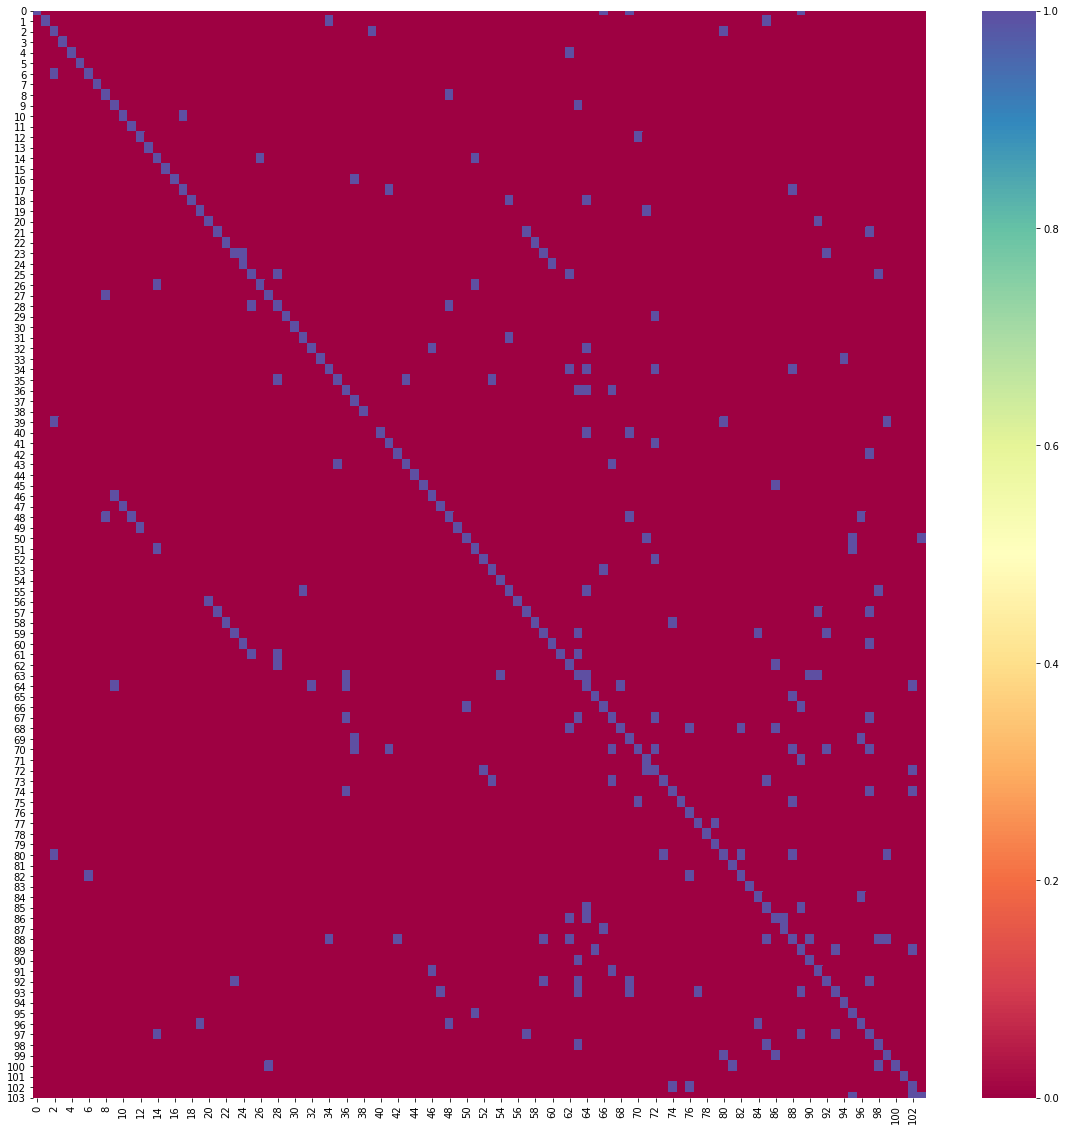

In [43]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs9 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs9, cmap="Spectral", robust=True)

#### Multiclass Precision, Recall and Accuracy

In [44]:
cr9 = classification_report(y_true, y_pred, digits=4)
print(cr9)

              precision    recall  f1-score   support

           0     1.0000    0.8125    0.8966        16
           1     1.0000    0.5000    0.6667         6
           2     0.7333    0.8462    0.7857        13
           3     1.0000    1.0000    1.0000         6
           4     1.0000    0.8000    0.8889         5
           5     1.0000    1.0000    1.0000         6
           6     0.9167    0.9167    0.9167        12
           7     1.0000    1.0000    1.0000         6
           8     0.7500    0.9000    0.8182        10
           9     0.8182    0.9000    0.8571        10
          10     0.8182    0.9000    0.8571        10
          11     0.9167    1.0000    0.9565        11
          12     0.9167    0.9167    0.9167        12
          13     1.0000    1.0000    1.0000        10
          14     0.3125    0.6250    0.4167         8
          15     1.0000    1.0000    1.0000         7
          16     1.0000    0.8571    0.9231         7
          17     0.8571    

#### T Test

In [41]:
sym2latex = {i.Index : i.latex for i in symbols.itertuples()}
latex2sym = {v: k for k, v in sym2latex.items()}

In [42]:
ms = ['hasyv2model.h5']
models = [load_model(dir_+z) for z in ms]

In [43]:
ms = [
    'hasyv2model.h5',
    'hasyv2model2.h5',
    'hasyv2model3.h5',
    'hasyv2model_stratified_kfold4.h5',
    'hasyv2model_stratified_kfold5.h5',
    'hasyv2model_stratified_kfold6.h5',
    'hasyv2model_stratified_kfold7.h5',
    'hasyv2model21.h5',
    'hasyv2model.h5'
     ]
models = [load_model(dir_+z) for z in ms]

In [44]:
ttest = t_test(X_test, y_test, models=models, sym2latex_dict=sym2latex)
ttest.head()

Predictng labels for Model 0
Predictng labels for Model 1
Predictng labels for Model 2
Predictng labels for Model 3
Predictng labels for Model 4
Predictng labels for Model 5
Predictng labels for Model 6
Predictng labels for Model 7
Predictng labels for Model 8
Predictions Done
Comparing Results...
Done


,symbol,latex,model0,model1,model2,model3,model4,model5,model6,model7,model8
0,171,\approx,\approx,\approx,\approx,\approx,\approx,\approx,\approx,\approx,\approx
1,68,\gamma,\gamma,\gamma,\gamma,\gamma,\gamma,\gamma,\gamma,\gamma,\gamma
2,67,\Sigma,\Sigma,\Sigma,\sum,\Sigma,\Sigma,\Sigma,\Sigma,\Sigma,\Sigma
3,224,\uparrow,\uparrow,\uparrow,\uparrow,\uparrow,\uparrow,\uparrow,\uparrow,\uparrow,\uparrow
4,72,\zeta,\zeta,\zeta,\zeta,\zeta,\zeta,\zeta,\zeta,\zeta,\zeta


In [45]:
t_test_report = create_t_test_report(ttest)
t_test_report.head()

,latex,total_count,model0,model1,model2,model3,model4,model5,model6,model7,model8,model0_acc,model1_acc,model2_acc,model3_acc,model4_acc,model5_acc,model6_acc,model7_acc,model8_acc
0,A,16,16,13,15,15,15,14,15,15,16,100.0,81.250000,93.750000,93.750000,93.750000,87.500000,93.750000,93.750000,100.0
1,B,6,6,4,5,5,4,4,5,4,6,100.0,66.666667,83.333333,83.333333,66.666667,66.666667,83.333333,66.666667,100.0
2,C,13,13,12,12,12,10,12,12,11,13,100.0,92.307692,92.307692,92.307692,76.923077,92.307692,92.307692,84.615385,100.0
3,D,6,6,5,6,2,6,5,6,6,6,100.0,83.333333,100.000000,33.333333,100.000000,83.333333,100.000000,100.000000,100.0
4,E,5,5,4,4,3,4,5,4,5,5,100.0,80.000000,80.000000,60.000000,80.000000,100.000000,80.000000,100.000000,100.0


### Convolutional Neural Networks
* CNN1: CNN with two convolutional and two dense layers
* CNN2: CNN with three convolutional and three dense layers
* CNN3: CNN with three convolutional and three dense layers with Batch Normalization

### Models
* model0: CNN1 on whole dataset
* model1: CNN1 with random split on dataset
* model2: CNN1 with stratified split on dataset
* model3: CNN1 with K Fold cross validation
* model4: CNN1 with K Fold cross vlidation
* model5: CNN1 with K Fold cross validation
* model6: CNN1 with K Fold cross validation
* model7: CNN2 with stratified split on dataset
* model8: CNN3 with stratified split on dataset

In [46]:
t_test_report

,latex,total_count,model0,model1,model2,model3,model4,model5,model6,model7,model8,model0_acc,model1_acc,model2_acc,model3_acc,model4_acc,model5_acc,model6_acc,model7_acc,model8_acc
0,A,16,16,13,15,15,15,14,15,15,16,100.000000,81.250000,93.750000,93.750000,93.750000,87.500000,93.750000,93.750000,100.000000
1,B,6,6,4,5,5,4,4,5,4,6,100.000000,66.666667,83.333333,83.333333,66.666667,66.666667,83.333333,66.666667,100.000000
2,C,13,13,12,12,12,10,12,12,11,13,100.000000,92.307692,92.307692,92.307692,76.923077,92.307692,92.307692,84.615385,100.000000
3,D,6,6,5,6,2,6,5,6,6,6,100.000000,83.333333,100.000000,33.333333,100.000000,83.333333,100.000000,100.000000,100.000000
4,E,5,5,4,4,3,4,5,4,5,5,100.000000,80.000000,80.000000,60.000000,80.000000,100.000000,80.000000,100.000000,100.000000
5,F,6,6,6,6,5,5,5,5,6,6,100.000000,100.000000,100.000000,83.333333,83.333333,83.333333,83.333333,100.000000,100.000000
6,G,12,12,11,12,12,12,12,11,10,12,100.000000,91.666667,100.000000,100.000000,100.000000,100.000000,91.666667,83.333333,100.000000
7,H,6,6,4,6,6,4,5,6,6,6,100.000000,66.666667,100.000000,100.000000,66.666667,83.333333,100.000000,100.000000,100.000000
8,I,10,8,8,8,6,7,8,4,8,8,80.000000,80.000000,80.000000,60.000000,70.000000,80.000000,40.000000,80.000000,80.000000
9,J,10,10,9,10,10,8,10,10,10,10,100.000000,90.000000,100.000000,100.000000,80.000000,100.000000,100.000000,100.000000,100.000000
